In [1]:
pip install pandas unicode matplotlib seaborn scikit-learn plotly scipy 

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
pd.set_option("mode.copy_on_write", True)

# 1. Preparation for OneClassSVM

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


combined_df = pd.read_csv('../data/output/consumo_datamart_silver_sectorecon_ohe.csv')
features_to_scale= ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']

X = combined_df[features_to_scale]
# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 4  
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit_transform(X_scaled)

labels = kmeans.labels_

combined_df['Cluster'] = labels

combined_df.head()

output_filepath = '../data/output/consumo_datamart_gold.csv'
combined_df.to_csv(output_filepath, index=False)

c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


# 2. Calibration of Contamination factor

In [3]:
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV

def silhouette_scorer(estimator, X, y=None):
    preds = estimator.fit_predict(X)
    if len(np.unique(preds)) > 1:  
        return silhouette_score(X, preds)
    else:
        return -1  

combined_df = pd.read_csv('../data/output/consumo_datamart_gold.csv')
features = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']
time_features= ['Dia_Sin', 'Dia_Cos','Hora_Sin','Hora_Cos','Mes_Sin','Mes_Cos']
final_features= features + time_features
data = combined_df[final_features].copy()
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Create One-Class SVM 
ocsvm = OneClassSVM(kernel='rbf')
param_grid = {
    'nu': [ 0.05, 0.1, 0.25,  0.4, 0.5 ]
}
# Create RandomizedSearch  
random_search = RandomizedSearchCV(ocsvm, param_distributions=param_grid,
                                   scoring=silhouette_scorer, cv=3, random_state=42)
# Perform random search
random_search.fit(data[features]) 
print("Best parameters:", random_search.best_params_)
print("Best silhouette score: {:.2f}".format(random_search.best_score_))



c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'nu': 0.05}
Best silhouette score: 0.36


# 3. Calculation of outliers/anomaly scores and Robustness in the global unidimensional perspective

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

def get_anomalies_ocsvm(df):
    df = df.copy()


    X = df
    y = df.index

    # Split the data into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    # Create and fit the One-Class SVM on the training data
    oc_svm = OneClassSVM(kernel='rbf', nu=0.05, gamma='auto')  # nu is an upper bound on the fraction of outliers
    oc_svm.fit(X_train)

    # Predict anomalies on the training and testing data
    train_preds = oc_svm.predict(X_train)
    test_preds = oc_svm.predict(X_test)

    train_score = oc_svm.decision_function(X_train)
    test_score = oc_svm.decision_function(X_test)

    # Calculate the percentage of anomalies detected in the training set
    anomaly_count_train = np.count_nonzero(train_preds == -1)
    total_train = len(train_preds)
    anomaly_percentage_train = (anomaly_count_train / total_train) * 100
    print(f"Percentage of anomalies detected in the training data: {anomaly_percentage_train:.3f}%")

    # Calculate the percentage of anomalies detected in the testing set
    anomaly_count_test = np.count_nonzero(test_preds == -1)
    total_test = len(test_preds)
    anomaly_percentage_test = (anomaly_count_test / total_test) * 100
    print(f"Percentage of anomalies detected in the test data: {anomaly_percentage_test:.3f}%")

    df.loc[y_train, 'Anomaly'] = train_preds
    df.loc[y_train, 'Anomaly_Score'] = train_score 
    
    df.loc[y_test, 'Anomaly'] = test_preds
    df.loc[y_test, 'Anomaly_Score'] = test_score
    
    return df


# 3. Calculo de outliers /score de anomalias y Robustez en la perspectiva global unidimensional

In [6]:
import pandas as pd




combined_df = pd.read_csv('../data/output/consumo_datamart_gold.csv')
features = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']
time_features= ['Dia_Sin', 'Dia_Cos','Hora_Sin','Hora_Cos','Mes_Sin','Mes_Cos']
final_features= features + time_features
combined_df['Anomaly']= pd.NA
combined_df['Anomaly_Score_Global']= pd.NA

data = combined_df[final_features].copy()
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

data[final_features + ['Anomaly', 'Anomaly_Score_Global']]= get_anomalies_ocsvm(data)
combined_df.update(data[['Anomaly','Anomaly_Score_Global']])

# Calculate and print the percentage of anomalies detected
anomaly_percentage = combined_df[combined_df['Anomaly'] == -1].shape[0] / combined_df.shape[0] * 100
print(f"Percentage of anomalies detected: {anomaly_percentage:.3f}%")

combined_df.rename(columns={'Anomaly':'Anomaly_Global'},inplace=True)

combined_df.to_csv('../data/output/consumo_datamart_gold.csv', index=False)


Percentage of anomalies detected in the training data: 5.000%
Percentage of anomalies detected in the test data: 4.791%
Percentage of anomalies detected: 4.958%


In [7]:
# Group by 'ClienteId' and calculate the percentage of anomalies
anomaly_percentage_global = combined_df.groupby('ClienteId')['Anomaly_Global'].apply(
    lambda x: (x == -1.0).sum()*100/len(combined_df)
).reset_index(name='Porc_sospechosos_global')

anomaly_percentage_global

,ClienteId,Porc_sospechosos_global
0,1,0.008847
1,2,0.000000
2,3,0.000216
3,4,0.039273
4,5,1.118843
5,6,0.288073
6,7,0.531046
7,8,0.496520
8,9,0.328856
9,10,0.719642


# 4 Calculation of outliers/anomaly scores and Robustness in the Client perspective

In [8]:

results = []
combined_df = pd.read_csv('../data/output/consumo_datamart_gold.csv')
features = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']
time_features= ['Dia_Sin', 'Dia_Cos','Hora_Sin','Hora_Cos','Mes_Sin','Mes_Cos']
final_features= features + time_features
combined_df['Anomaly_Score_Cliente'] = pd.NA
combined_df['Anomaly'] = pd.NA

clients = sorted(list(combined_df['ClienteId'].unique()))
for idclient in sorted(clients):
    data = combined_df[combined_df['ClienteId'] == idclient].copy()
    scaler = StandardScaler()
    data[features] = scaler.fit_transform(data[features])
    data =data[final_features]
    data[final_features + ['Anomaly','Anomaly_Score_Cliente' ]]=get_anomalies_ocsvm(data)
    combined_df.update(data[['Anomaly','Anomaly_Score_Cliente']])
    anomalies_data = data[data['Anomaly'] == -1]
    # Calculate the percentage of anomalies detected
    anomaly_percentage_by_client = anomalies_data.shape[0]/data.shape[0]
   
    
    results.append((idclient,  anomaly_percentage_by_client * 100, 
                    combined_df[combined_df['ClienteId'] == idclient]['Sector_Economico'].iloc[0] ))
anomaly_percentages_by_client = pd.DataFrame(results, 
                                      columns=['ClienteId', 
                                               'Porc_sospechosos_cliente',
                                               'Sector_Economico'])

anomaly_percentages_by_client.sort_values(by='Porc_sospechosos_cliente', ascending=False)


combined_df.rename(columns={'Anomaly':'Anomaly_Cliente'},inplace=True)

combined_df.to_csv('../data/output/consumo_datamart_gold.csv', index=False)
   

Percentage of anomalies detected in the training data: 4.992%
Percentage of anomalies detected in the test data: 5.055%
Percentage of anomalies detected in the training data: 5.024%
Percentage of anomalies detected in the test data: 6.045%
Percentage of anomalies detected in the training data: 5.043%
Percentage of anomalies detected in the test data: 5.309%
Percentage of anomalies detected in the training data: 4.999%
Percentage of anomalies detected in the test data: 4.699%
Percentage of anomalies detected in the training data: 5.018%
Percentage of anomalies detected in the test data: 5.207%
Percentage of anomalies detected in the training data: 5.011%
Percentage of anomalies detected in the test data: 5.207%
Percentage of anomalies detected in the training data: 5.011%
Percentage of anomalies detected in the test data: 4.775%
Percentage of anomalies detected in the training data: 5.011%
Percentage of anomalies detected in the test data: 5.004%
Percentage of anomalies detected in the 

# 5 Calculation of outliers/anomaly scores and Robustness from  the lens of economical sector

In [9]:
results = []
sectors = sorted(list(combined_df['Sector_Economico'].unique()))
features = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']
time_features= ['Dia_Sin', 'Dia_Cos','Hora_Sin','Hora_Cos','Mes_Sin','Mes_Cos']
final_features= features + time_features
combined_df = pd.read_csv('../data/output/consumo_datamart_gold.csv')
combined_df['Anomaly_Score_Sector'] = pd.NA
combined_df['Anomaly'] = pd.NA
anomaly_percentage_sector_consolidado= pd.DataFrame()
for sector in sectors:
    data_orig = combined_df[combined_df['Sector_Economico'] == sector]
    data = data_orig[final_features].copy()
    scaler = StandardScaler()
    data[features] = scaler.fit_transform(data[features])
    data_orig[final_features + ['Anomaly','Anomaly_Score_Sector']]=get_anomalies_ocsvm(data)
    combined_df.update(data_orig[['Anomaly','Anomaly_Score_Sector']])
    anomaly_percentage_sector = data_orig.groupby('ClienteId')['Anomaly'].apply(
        lambda x: (x == -1.0).sum()*100/len(data_orig)
    ).reset_index(name='Porc_sospechosos_sector')

    anomaly_percentage_sector_consolidado = pd.concat([anomaly_percentage_sector_consolidado, 
                                                       anomaly_percentage_sector], ignore_index=True)


combined_df.rename(columns={'Anomaly':'Anomaly_Sector'},inplace=True)

combined_df.to_csv('../data/output/consumo_datamart_gold.csv', index=False)


Percentage of anomalies detected in the training data: 5.004%
Percentage of anomalies detected in the test data: 5.272%
Percentage of anomalies detected in the training data: 5.006%
Percentage of anomalies detected in the test data: 4.893%
Percentage of anomalies detected in the training data: 4.999%
Percentage of anomalies detected in the test data: 5.214%
Percentage of anomalies detected in the training data: 4.983%
Percentage of anomalies detected in the test data: 4.908%
Percentage of anomalies detected in the training data: 5.009%
Percentage of anomalies detected in the test data: 6.321%
Percentage of anomalies detected in the training data: 5.001%
Percentage of anomalies detected in the test data: 5.320%
Percentage of anomalies detected in the training data: 4.993%
Percentage of anomalies detected in the test data: 5.072%


# 6. Calculation of outliers/anomaly scores and Robustness from  the lens of the clusters

In [10]:
results = []
sectors = sorted(list(combined_df['Sector_Economico'].unique()))
features = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']
time_features= ['Dia_Sin', 'Dia_Cos','Hora_Sin','Hora_Cos','Mes_Sin','Mes_Cos']
final_features= features + time_features
combined_df = pd.read_csv('../data/output/consumo_datamart_gold.csv')
combined_df['Anomaly_Score_Cluster'] = pd.NA
combined_df['Anomaly'] = pd.NA
clusters = sorted(list(combined_df['Cluster'].unique()))
anomaly_percentage_cluster_consolidado= pd.DataFrame()
for cluster in clusters:
    data_orig = combined_df[combined_df['Cluster'] == cluster]
    data = data_orig[final_features].copy()
    scaler = StandardScaler()
    data[features] = scaler.fit_transform(data[features])
    data_orig[final_features + ['Anomaly','Anomaly_Score_Cluster']]=get_anomalies_ocsvm(data)
    combined_df.update(data_orig[['Anomaly','Anomaly_Score_Cluster']])
    anomaly_percentage_cluster = data_orig.groupby('ClienteId')['Anomaly'].apply(
        lambda x: (x == -1.0).sum()*100/len(data_orig)
    ).reset_index(name='Porc_sospechosos_cluster')
    anomaly_percentage_cluster['Cluster']=cluster
    
  
  
    anomaly_percentage_cluster_consolidado = pd.concat([anomaly_percentage_cluster_consolidado, 
                                                       anomaly_percentage_cluster], ignore_index=True)
    
combined_df.rename(columns={'Anomaly':'Anomaly_Cluster'},inplace=True)

combined_df.to_csv('../data/output/consumo_datamart_gold.csv', index=False)






Percentage of anomalies detected in the training data: 5.000%
Percentage of anomalies detected in the test data: 4.847%
Percentage of anomalies detected in the training data: 4.998%
Percentage of anomalies detected in the test data: 5.144%
Percentage of anomalies detected in the training data: 5.001%
Percentage of anomalies detected in the test data: 5.024%
Percentage of anomalies detected in the training data: 4.999%
Percentage of anomalies detected in the test data: 4.995%


In [11]:
merged_df = pd.merge(anomaly_percentage_global, 
                    anomaly_percentages_by_client, 
                     on='ClienteId', 
                     how='inner')
merged_df = pd.merge(merged_df, 
                    anomaly_percentage_sector_consolidado, 
                     on='ClienteId', 
                     how='inner')
merged_df = pd.merge(merged_df, 
                    anomaly_percentage_cluster_consolidado, 
                     on='ClienteId', 
                     how='inner')
merged_df.to_csv('../data/output/porcentaje_anomalias_consolidado.csv', index=False)


In [12]:
import pandas as pd
anomaly_percentage = pd.read_csv('../data/output/porcentaje_anomalias_consolidado.csv')


# Sort the DataFrame first by 'Sector_Economico' and then by 'Porc_sospechosos_sector' in descending order
sorted_df = anomaly_percentage.sort_values(by=['Sector_Economico', 'Porc_sospechosos_sector'], ascending=[True, False])

# Now display the sorted DataFrame
for sector in sorted_df['Sector_Economico'].unique():
    print(f"---- {sector} ----")
    df= sorted_df[sorted_df['Sector_Economico'] == sector].drop_duplicates(subset=['ClienteId'])
    display(df)
    


---- captacion_tratamiento_distribucion_agua ----


,ClienteId,Porc_sospechosos_global,Porc_sospechosos_cliente,Sector_Economico,Porc_sospechosos_sector,Porc_sospechosos_cluster,Cluster
54,18,0.106382,4.953846,captacion_tratamiento_distribucion_agua,1.910769,0.436300,0
60,20,0.615634,5.097436,captacion_tratamiento_distribucion_agua,1.258462,1.412026,0
57,19,0.025031,5.220513,captacion_tratamiento_distribucion_agua,1.112821,0.000000,0
48,16,0.003021,5.025641,captacion_tratamiento_distribucion_agua,0.498462,0.000000,0
51,17,0.007552,4.943590,captacion_tratamiento_distribucion_agua,0.276923,0.053943,0


---- cultivo_arboles_frutales_nueces ----


,ClienteId,Porc_sospechosos_global,Porc_sospechosos_cliente,Sector_Economico,Porc_sospechosos_sector,Porc_sospechosos_cluster,Cluster
30,9,0.328856,4.969260,cultivo_arboles_frutales_nueces,1.475535,1.096303,0
33,10,0.719642,4.954017,cultivo_arboles_frutales_nueces,1.184899,0.000000,0
26,8,0.496520,5.009908,cultivo_arboles_frutales_nueces,0.958285,0.033317,0
22,7,0.531046,4.964179,cultivo_arboles_frutales_nueces,0.791626,0.022212,0
18,6,0.288073,5.050556,cultivo_arboles_frutales_nueces,0.573142,0.309376,0


---- cultivo_frutos_nueces_arboles_arbustos ----


,ClienteId,Porc_sospechosos_global,Porc_sospechosos_cliente,Sector_Economico,Porc_sospechosos_sector,Porc_sospechosos_cluster,Cluster
39,12,0.010573,5.203679,cultivo_frutos_nueces_arboles_arbustos,2.868108,0.003173,0
46,15,0.000000,5.071429,cultivo_frutos_nueces_arboles_arbustos,1.362913,0.003173,0
37,11,0.007121,5.078571,cultivo_frutos_nueces_arboles_arbustos,0.791912,0.000000,0
44,14,0.000216,5.007143,cultivo_frutos_nueces_arboles_arbustos,0.018721,0.001587,0


---- cultivo_hortalizas ----


,ClienteId,Porc_sospechosos_global,Porc_sospechosos_cliente,Sector_Economico,Porc_sospechosos_sector,Porc_sospechosos_cluster,Cluster
69,23,0.123213,5.165266,cultivo_hortalizas,2.727171,0.250674,0
71,24,0.005395,5.299720,cultivo_hortalizas,0.925490,0.150722,0
66,22,0.102282,5.165266,cultivo_hortalizas,0.786555,0.153895,0
63,21,0.014026,5.120448,cultivo_hortalizas,0.307003,0.169760,0
74,25,0.069483,5.042017,cultivo_hortalizas,0.221849,0.053943,0


---- cultivo_hortalizas_melones_raices_tuberculos ----


,ClienteId,Porc_sospechosos_global,Porc_sospechosos_cliente,Sector_Economico,Porc_sospechosos_sector,Porc_sospechosos_cluster,Cluster
42,13,0.102498,5.271429,cultivo_hortalizas_melones_raices_tuberculos,5.271429,0.001587,0


---- elaboracion_cacao_chocolate_productos_confiteria ----


,ClienteId,Porc_sospechosos_global,Porc_sospechosos_cliente,Sector_Economico,Porc_sospechosos_sector,Porc_sospechosos_cluster,Cluster
14,5,1.118843,5.055637,elaboracion_cacao_chocolate_productos_confiteria,2.599461,0.528320,0
11,4,0.039273,4.938773,elaboracion_cacao_chocolate_productos_confiteria,1.384076,0.087260,0
7,3,0.000216,5.096286,elaboracion_cacao_chocolate_productos_confiteria,0.803821,0.001587,0
0,1,0.008847,5.004827,elaboracion_cacao_chocolate_productos_confiteria,0.210355,0.007933,0
3,2,0.000000,5.228393,elaboracion_cacao_chocolate_productos_confiteria,0.067070,0.006346,0


---- venta_mayor_metales_minerales_metaliferos ----


,ClienteId,Porc_sospechosos_global,Porc_sospechosos_cliente,Sector_Economico,Porc_sospechosos_sector,Porc_sospechosos_cluster,Cluster
83,28,0.005395,5.291283,venta_mayor_metales_minerales_metaliferos,1.662724,0.004760,0
79,27,0.064520,5.116075,venta_mayor_metales_minerales_metaliferos,1.345598,0.025385,0
87,29,0.111129,5.072273,venta_mayor_metales_minerales_metaliferos,1.293035,0.128510,0
90,30,0.010573,5.203679,venta_mayor_metales_minerales_metaliferos,0.527376,0.003173,0
76,26,0.042725,5.054753,venta_mayor_metales_minerales_metaliferos,0.180464,0.023798,0


In [18]:
import pandas as pd
anomaly_percentage = pd.read_csv('../data/output/porcentaje_anomalias_consolidado.csv')


# Sort the DataFrame first by 'Sector_Economico' and then by 'Porc_sospechosos_sector' in descending order
sorted_df = anomaly_percentage.sort_values(by=['Sector_Economico', 'Porc_sospechosos_sector'], ascending=[True, False])

# Now display the sorted DataFrame
for cluster in sorted_df['Cluster'].unique():
    print(f"---- {cluster} ----")
    display(sorted_df[sorted_df['Cluster'] == cluster])

---- 0 ----


,ClienteId,Porc_sospechosos_global,Porc_sospechosos_cliente,Sector_Economico,Porc_sospechosos_sector,Porc_sospechosos_cluster,Cluster
54,18,0.015105,0.266667,captacion_tratamiento_distribucion_agua,0.034872,0.000000,0
57,19,0.005395,0.230769,captacion_tratamiento_distribucion_agua,0.022564,0.000000,0
51,17,0.000432,0.205128,captacion_tratamiento_distribucion_agua,0.021538,0.000000,0
60,20,0.010358,0.189744,captacion_tratamiento_distribucion_agua,0.012308,0.000000,0
48,16,0.001942,0.174359,captacion_tratamiento_distribucion_agua,0.008205,0.000000,0
30,9,0.029562,0.975560,cultivo_arboles_frutales_nueces,0.140237,0.061875,0
18,6,0.026326,1.209288,cultivo_arboles_frutales_nueces,0.120929,0.052356,0
22,7,0.017479,0.436970,cultivo_arboles_frutales_nueces,0.080280,0.001587,0
26,8,0.010358,0.533509,cultivo_arboles_frutales_nueces,0.051827,0.009519,0
33,10,0.006905,0.675779,cultivo_arboles_frutales_nueces,0.028454,0.000000,0


---- 1 ----


,ClienteId,Porc_sospechosos_global,Porc_sospechosos_cliente,Sector_Economico,Porc_sospechosos_sector,Porc_sospechosos_cluster,Cluster
55,18,0.015105,0.266667,captacion_tratamiento_distribucion_agua,0.034872,0.006703,1
58,19,0.005395,0.230769,captacion_tratamiento_distribucion_agua,0.022564,0.020108,1
52,17,0.000432,0.205128,captacion_tratamiento_distribucion_agua,0.021538,0.026811,1
61,20,0.010358,0.189744,captacion_tratamiento_distribucion_agua,0.012308,0.000000,1
49,16,0.001942,0.174359,captacion_tratamiento_distribucion_agua,0.008205,0.003351,1
19,6,0.026326,1.209288,cultivo_arboles_frutales_nueces,0.120929,0.072055,1
23,7,0.017479,0.436970,cultivo_arboles_frutales_nueces,0.080280,0.041892,1
27,8,0.010358,0.533509,cultivo_arboles_frutales_nueces,0.051827,0.065352,1
34,10,0.006905,0.675779,cultivo_arboles_frutales_nueces,0.028454,0.070379,1
40,12,0.000000,0.341656,cultivo_frutos_nueces_arboles_arbustos,0.073013,0.000000,1


---- 2 ----


,ClienteId,Porc_sospechosos_global,Porc_sospechosos_cliente,Sector_Economico,Porc_sospechosos_sector,Porc_sospechosos_cluster,Cluster
56,18,0.015105,0.266667,captacion_tratamiento_distribucion_agua,0.034872,0.000574,2
59,19,0.005395,0.230769,captacion_tratamiento_distribucion_agua,0.022564,0.000000,2
53,17,0.000432,0.205128,captacion_tratamiento_distribucion_agua,0.021538,0.000000,2
62,20,0.010358,0.189744,captacion_tratamiento_distribucion_agua,0.012308,0.034431,2
50,16,0.001942,0.174359,captacion_tratamiento_distribucion_agua,0.008205,0.000000,2
31,9,0.029562,0.975560,cultivo_arboles_frutales_nueces,0.140237,0.000574,2
20,6,0.026326,1.209288,cultivo_arboles_frutales_nueces,0.120929,0.013772,2
24,7,0.017479,0.436970,cultivo_arboles_frutales_nueces,0.080280,0.006312,2
28,8,0.010358,0.533509,cultivo_arboles_frutales_nueces,0.051827,0.008608,2
35,10,0.006905,0.675779,cultivo_arboles_frutales_nueces,0.028454,0.000000,2


---- 3 ----


,ClienteId,Porc_sospechosos_global,Porc_sospechosos_cliente,Sector_Economico,Porc_sospechosos_sector,Porc_sospechosos_cluster,Cluster
32,9,0.029562,0.975560,cultivo_arboles_frutales_nueces,0.140237,0.079901,3
21,6,0.026326,1.209288,cultivo_arboles_frutales_nueces,0.120929,0.053468,3
25,7,0.017479,0.436970,cultivo_arboles_frutales_nueces,0.080280,0.033042,3
29,8,0.010358,0.533509,cultivo_arboles_frutales_nueces,0.051827,0.021027,3
36,10,0.006905,0.675779,cultivo_arboles_frutales_nueces,0.028454,0.009612,3
41,12,0.000000,0.341656,cultivo_frutos_nueces_arboles_arbustos,0.073013,0.000000,3
68,22,0.001295,0.403361,cultivo_hortalizas,0.035854,0.000000,3
73,24,0.000000,0.436975,cultivo_hortalizas,0.013445,0.000000,3
65,21,0.000216,0.324930,cultivo_hortalizas,0.006723,0.000000,3
13,4,0.002158,0.401402,elaboracion_cacao_chocolate_productos_confiteria,0.045729,0.000000,3


# 8. Distribution of anomaly scores for each perspective

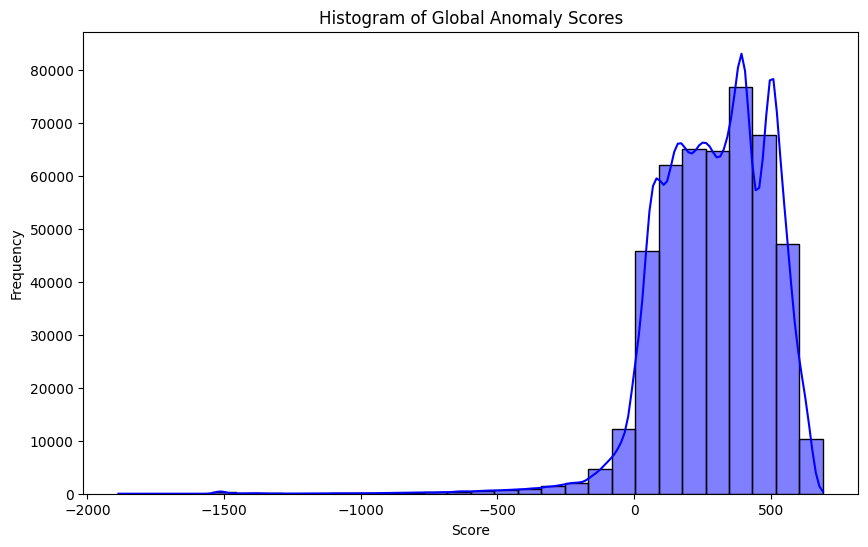

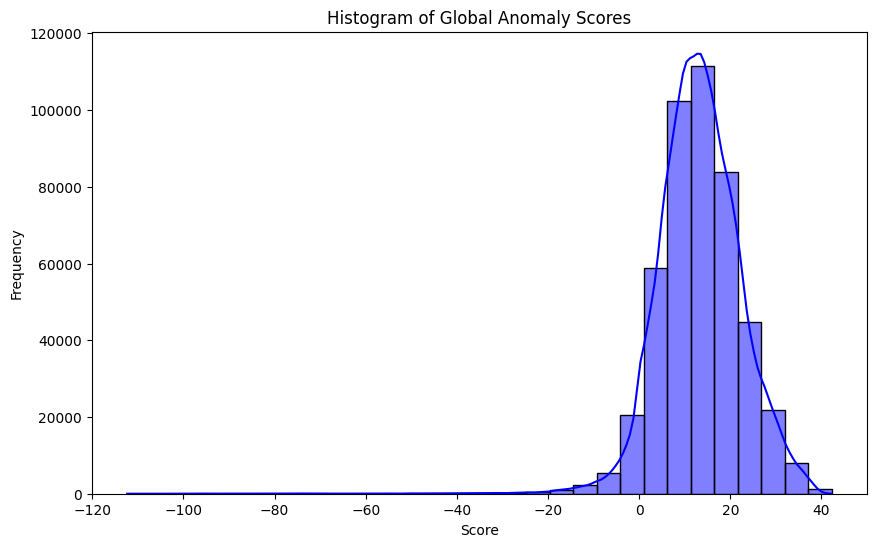

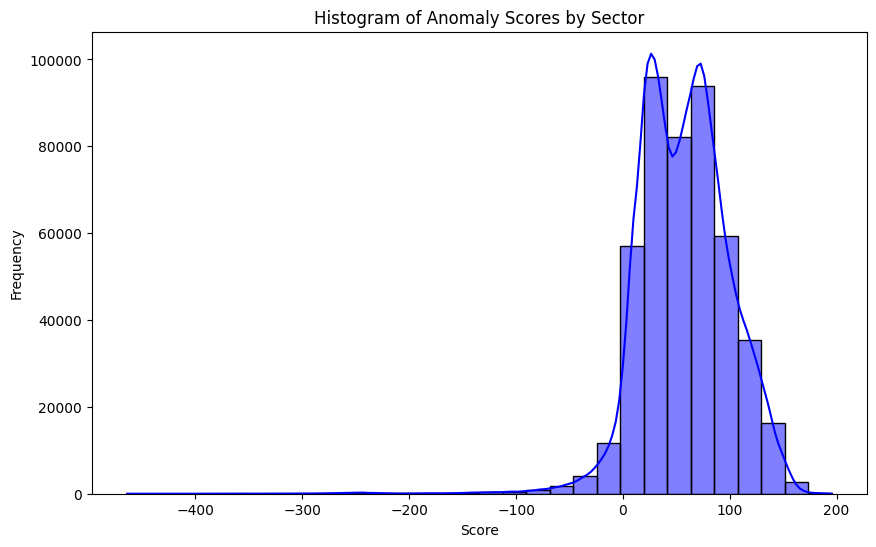

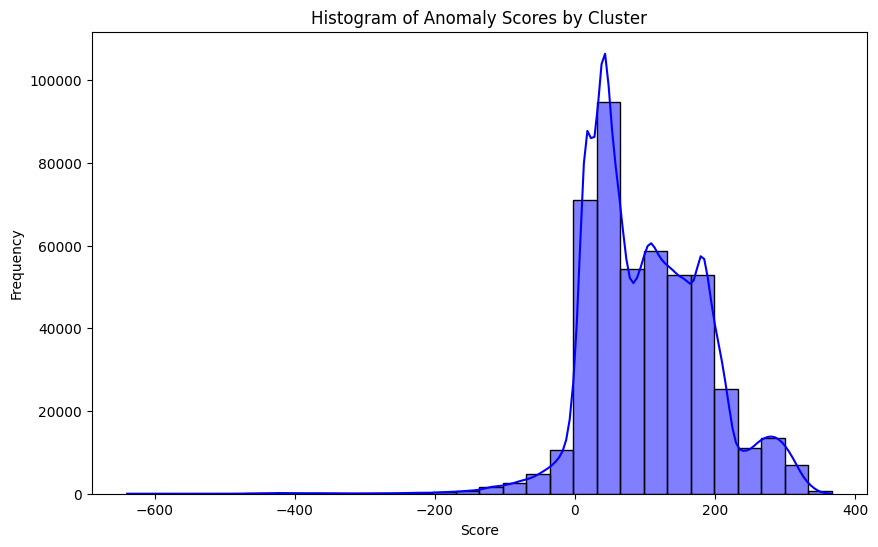

In [13]:

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

combined_df = pd.read_csv('../data/output/consumo_datamart_gold.csv')


# plot histograms
def plot_histogram(data, column, title, bins=30, color='blue'):
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], bins=bins, kde=True, color=color)
    plt.title(title)
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.show()

# Plotting histograms 
plot_histogram(combined_df, 'Anomaly_Score_Global', 'Histogram of Global Anomaly Scores')
plot_histogram(combined_df, 'Anomaly_Score_Cliente', 'Histogram of Global Anomaly Scores')
plot_histogram(combined_df, 'Anomaly_Score_Sector', 'Histogram of Anomaly Scores by Sector')
plot_histogram(combined_df, 'Anomaly_Score_Cluster', 'Histogram of Anomaly Scores by Cluster')


# 8. Plot of outliers for  the four consumption variables

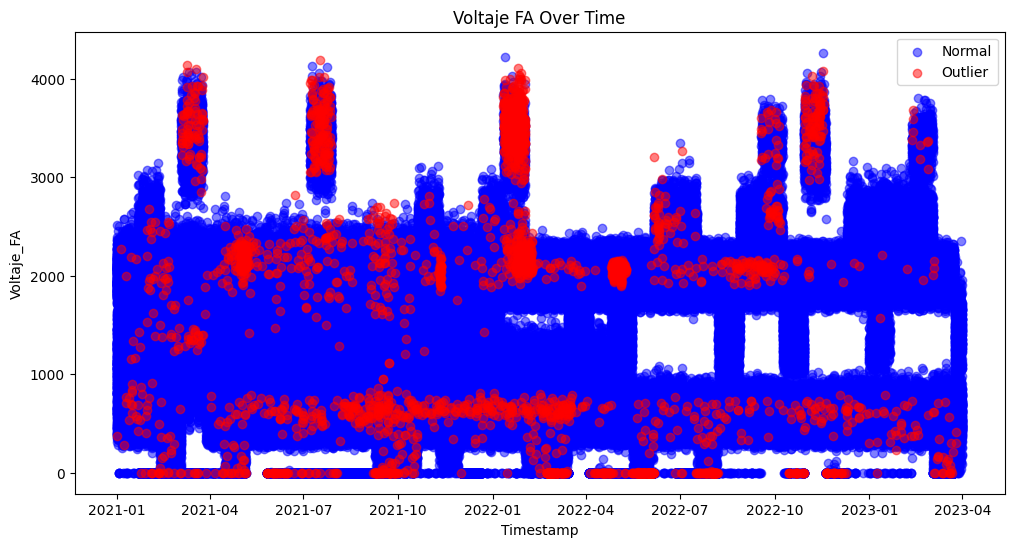

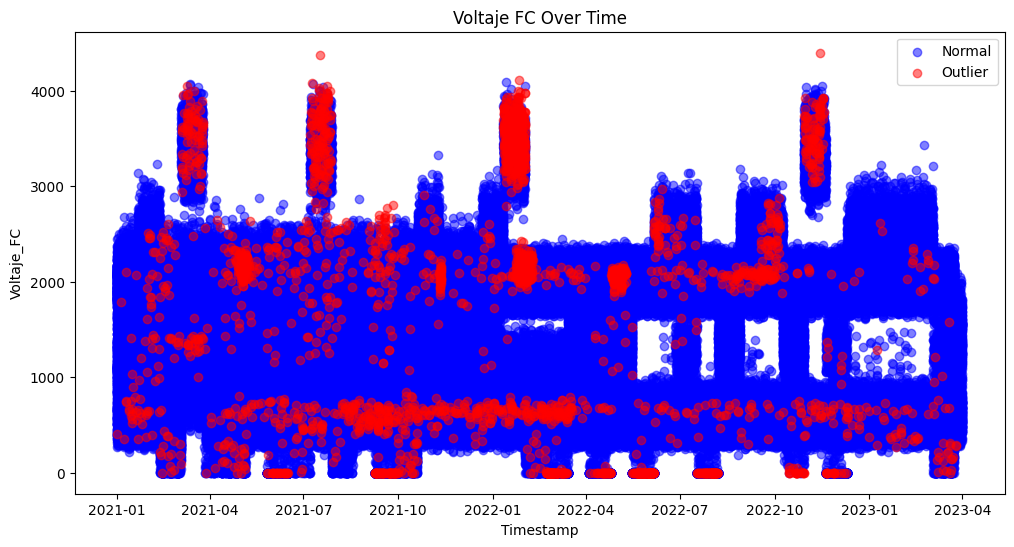

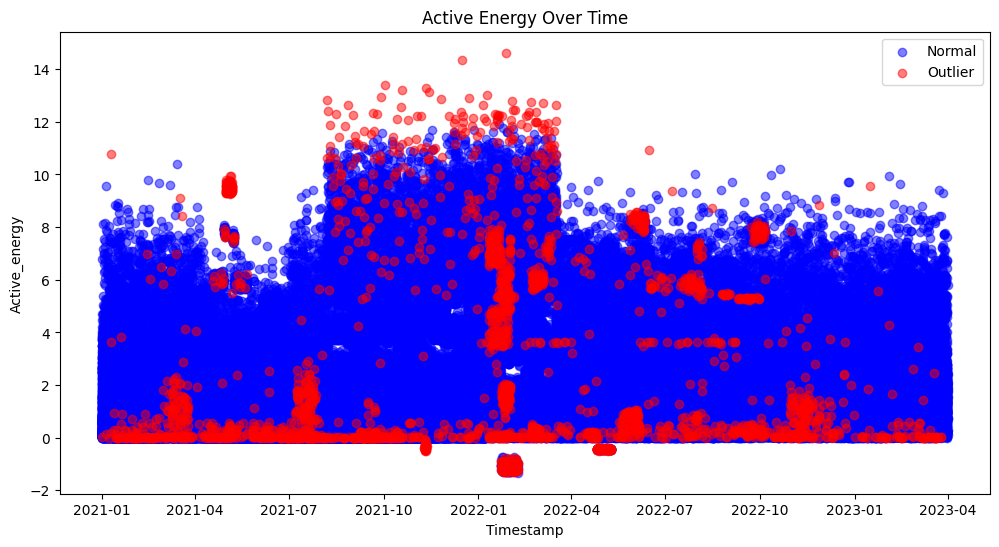

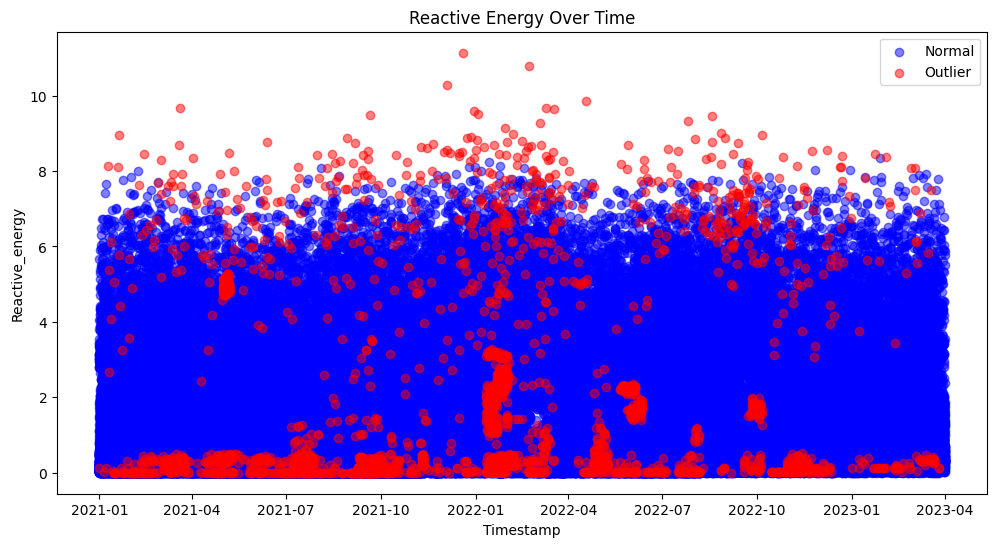

In [14]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('../data/output/consumo_datamart_gold.csv')
df['Fecha'] = pd.to_datetime(df['Fecha'])

df_sampled = df.sample(frac=1)

# Define a function to determine if a row is an outlier
def is_outlier(row):
    if (row['Anomaly_Cluster'] == -1 and
        row['Anomaly_Sector'] == -1 and
        row['Anomaly_Cliente'] == -1 and
        row['Anomaly_Global'] == -1):
        return -1
    else:
        return 1

# Apply the function to each row
df_sampled['Outlier_Label'] = df_sampled.apply(is_outlier, axis=1)

# Function to create plots
def plot_data(df, x, y, hue, title):
    plt.figure(figsize=(12, 6))
    # Plot normal observations
    plt.scatter(df[x][df[hue] == 1], df[y][df[hue] == 1], c='blue', label='Normal', alpha=0.5)
    # Plot outliers
    plt.scatter(df[x][df[hue] == -1], df[y][df[hue] == -1], c='red', label='Outlier', alpha=0.5)
    plt.title(title)
    plt.xlabel('Timestamp')
    plt.ylabel(y)
    plt.legend()
    plt.show()

# Plotting 
plot_data(df_sampled, 'Fecha', 'Voltaje_FA', 'Outlier_Label', 'Voltaje FA Over Time')
plot_data(df_sampled, 'Fecha', 'Voltaje_FC', 'Outlier_Label', 'Voltaje FC Over Time')
plot_data(df_sampled, 'Fecha', 'Active_energy', 'Outlier_Label', 'Active Energy Over Time')
plot_data(df_sampled, 'Fecha', 'Reactive_energy', 'Outlier_Label', 'Reactive Energy Over Time')


# 9. Experiment to determine the behaviour of the outliers for when we have various levels of contamination, searching for observations that are outliers in all contamination factors.

In [16]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV


combined_df = pd.read_csv('../data/output/consumo_datamart_gold.csv')
features = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']
time_features= ['Dia_Sin', 'Dia_Cos','Hora_Sin','Hora_Cos','Mes_Sin','Mes_Cos']
final_features= features + time_features
scaler = StandardScaler()
combined_df[features] = scaler.fit_transform(combined_df[features])


# Range of contamination factors to test.
contamination_factors = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
outliers_detected = {}  

for cont in contamination_factors:

    oc_svm = OneClassSVM(kernel='rbf', nu=cont, gamma='auto')  
   
    # Fit the model
    oc_svm.fit(combined_df[final_features])
    
    # Predict the outliers (-1 for outliers, 1 for inliers)
    predictions = oc_svm.predict(combined_df[final_features])
    
    # Get the indices of outliers
    outlier_indices = np.where(predictions == -1)[0]
    
    # Store the outlier indices in the dictionary
    outliers_detected[cont] = set(outlier_indices)


consistent_outliers = set.intersection(*outliers_detected.values())


consistent_outliers_list = list(consistent_outliers)

# Print the results
print(f"Consistent outliers detected across all contamination factors: {consistent_outliers_list}")








Consistent outliers detected across all contamination factors: [376833, 425985, 434179, 32772, 434177, 24582, 401415, 434180, 434181, 434182, 401420, 401421, 425996, 393231, 434189, 434190, 434191, 32787, 434192, 434193, 434195, 434196, 32792, 204824, 376857, 32795, 434197, 434198, 434199, 434200, 434204, 368673, 434210, 450593, 368676, 434212, 401446, 24617, 32812, 368685, 426030, 450606, 221233, 434225, 434227, 376884, 426037, 426038, 426039, 434228, 434229, 434230, 401467, 426044, 434235, 401470, 426049, 434243, 368708, 434245, 368712, 434249, 426058, 426059, 426061, 434253, 376912, 434256, 401495, 434267, 204892, 434268, 368734, 32864, 450657, 434276, 450662, 434279, 221288, 204905, 434282, 434283, 434284, 450663, 434286, 368756, 450676, 416849, 213113, 368762, 434302, 213119, 434303, 434305, 434307, 434309, 393350, 204941, 434318, 434320, 434321, 368786, 401555, 434322, 434323, 434325, 434326, 450706, 434329, 450708, 401570, 450724, 450725, 393382, 213159, 213163, 204973, 237741, 

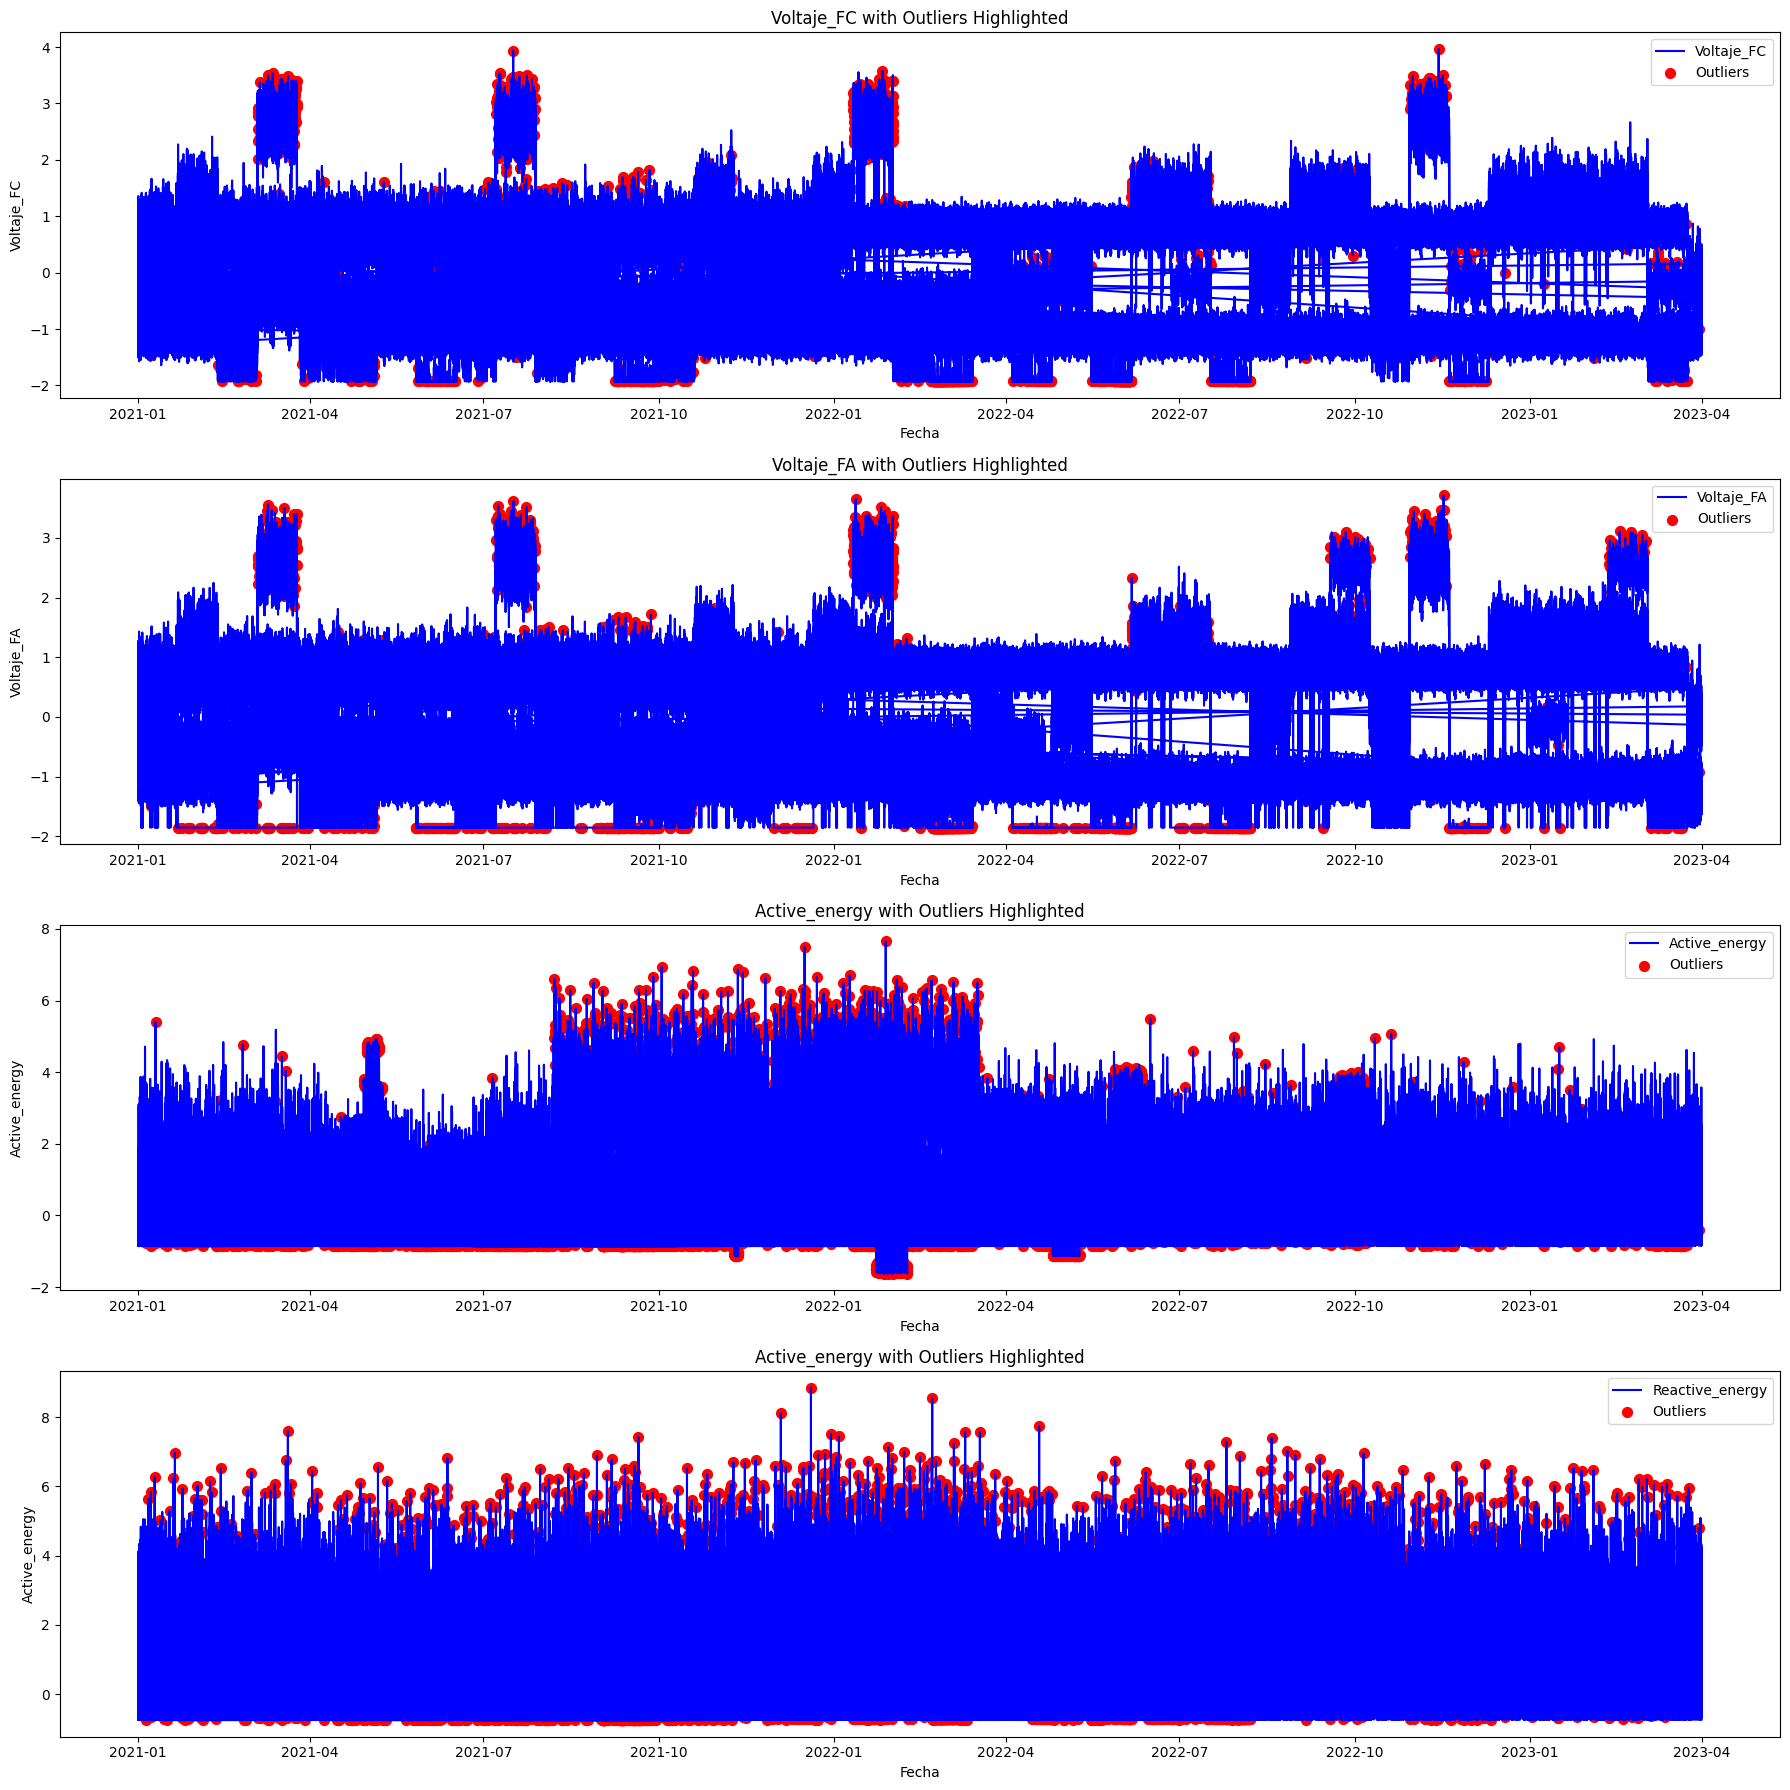

In [17]:
import matplotlib.pyplot as plt
import pandas as pd


#  'consistent_outliers_list' contains the indices of consistent outliers


combined_df['Fecha'] = pd.to_datetime(combined_df['Fecha'])


fig, axs = plt.subplots(4, 1, figsize=(18, 18))  # 2 rows, 1 column

# Plot for Voltaje_FC
axs[0].plot(combined_df['Fecha'], combined_df['Voltaje_FC'], 'b-', label='Voltaje_FC', markersize=5)
axs[0].scatter(combined_df.loc[consistent_outliers_list, 'Fecha'], combined_df.loc[consistent_outliers_list, 'Voltaje_FC'], color='red', s=50, label='Outliers')
axs[0].set_title('Voltaje_FC with Outliers Highlighted')
axs[0].set_xlabel('Fecha')
axs[0].set_ylabel('Voltaje_FC')
axs[0].legend()

# Plot for Voltaje_FA
axs[1].plot(combined_df['Fecha'], combined_df['Voltaje_FA'], 'b-', label='Voltaje_FA', markersize=5)
axs[1].scatter(combined_df.loc[consistent_outliers_list, 'Fecha'], combined_df.loc[consistent_outliers_list, 'Voltaje_FA'], color='red', s=50, label='Outliers')
axs[1].set_title('Voltaje_FA with Outliers Highlighted')
axs[1].set_xlabel('Fecha')
axs[1].set_ylabel('Voltaje_FA')
axs[1].legend()

# Plot for Voltaje_FA
axs[2].plot(combined_df['Fecha'], combined_df['Active_energy'], 'b-', label='Active_energy', markersize=5)
axs[2].scatter(combined_df.loc[consistent_outliers_list, 'Fecha'], combined_df.loc[consistent_outliers_list, 'Active_energy'], color='red', s=50, label='Outliers')
axs[2].set_title('Active_energy with Outliers Highlighted')
axs[2].set_xlabel('Fecha')
axs[2].set_ylabel('Active_energy')
axs[2].legend()

axs[3].plot(combined_df['Fecha'], combined_df['Reactive_energy'], 'b-', label='Reactive_energy', markersize=5)
axs[3].scatter(combined_df.loc[consistent_outliers_list, 'Fecha'], combined_df.loc[consistent_outliers_list, 'Reactive_energy'], color='red', s=50, label='Outliers')
axs[3].set_title('Active_energy with Outliers Highlighted')
axs[3].set_xlabel('Fecha')
axs[3].set_ylabel('Active_energy')
axs[3].legend()


plt.tight_layout()


plt.show()
